In [1]:
import pandas as pd
# from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
# Read the CSV file
df = pd.read_csv('temperature_log_2.csv')

# Rename the temperature columns to something simpler
df = df.rename(columns={
    'Temperature Sensor 1._temperature._tcp.local.': 'temp1',
    'Temperature Sensor 2._temperature._tcp.local.': 'temp2'
})

# Convert timestamp string to datetime
df['timestamp'] = pd.to_datetime(df['Timestamp'])

# Drop the original Timestamp column
df = df.drop('Timestamp', axis=1)

# Replace 'ERROR' with NaN (Not a Number)
df['temp1'] = pd.to_numeric(df['temp1'], errors='coerce')
df['temp2'] = pd.to_numeric(df['temp2'], errors='coerce')

# Display the first few rows and basic statistics
print("First few rows of the parsed data:")
print(df.head())
print("\nBasic statistics:")
print(df.describe())

First few rows of the parsed data:
   temp1  temp2           timestamp
0  20.56  13.62 2025-01-31 14:54:50
1  20.56  13.62 2025-01-31 14:55:21
2  20.56  13.56 2025-01-31 14:55:52
3  20.50  13.56 2025-01-31 14:56:24
4  20.44  13.31 2025-01-31 14:56:56

Basic statistics:
             temp1        temp2                      timestamp
count  2481.000000  2479.000000                           2481
mean     19.892310    11.956656  2025-02-01 01:46:05.570737664
min      18.060000    11.120000            2025-01-31 14:54:50
25%      19.120000    11.560000            2025-01-31 20:20:11
50%      20.250000    11.750000            2025-02-01 01:45:51
75%      20.560000    11.940000            2025-02-01 07:11:55
max      21.120000    14.000000            2025-02-01 12:38:14
std       0.862142     0.703938                            NaN


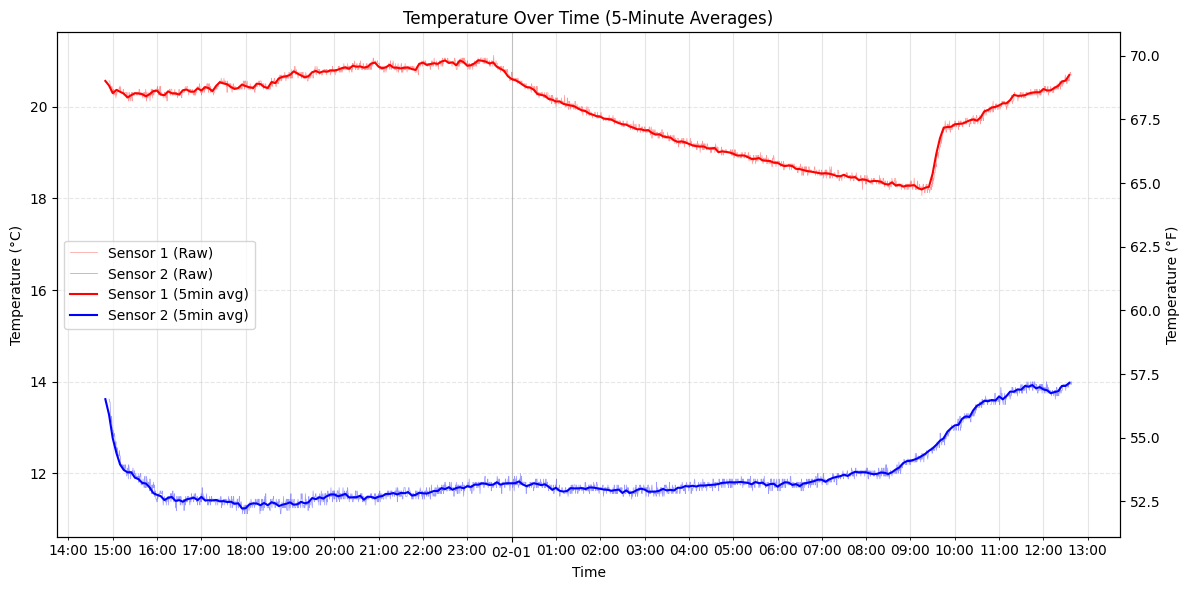

In [3]:
# Number of minutes to resample
resample_minutes = 5

# Resample data for both sensors
df_resampled1 = df.set_index('timestamp').resample(f'{resample_minutes}min')['temp1'].mean()
df_resampled2 = df.set_index('timestamp').resample(f'{resample_minutes}min')['temp2'].mean()

# Create the figure and axis with a larger size
fig, ax1 = plt.subplots(figsize=(12, 6))

# Create secondary axis for Fahrenheit
ax2 = ax1.twinx()

# Plot on primary axis (Celsius)
# Original data (thinner lines)
ax1.plot(df['timestamp'], df['temp1'], '-r', linewidth=0.5, alpha=0.4, label='Sensor 1 (Raw)')
ax1.plot(df['timestamp'], df['temp2'], '-b', linewidth=0.5, alpha=0.4, label='Sensor 2 (Raw)')

# Plot averaged temperature vs time (thicker lines)
ax1.plot(df_resampled1.index, df_resampled1.values, '-r', linewidth=1.5, label=f'Sensor 1 ({resample_minutes}min avg)')
ax1.plot(df_resampled2.index, df_resampled2.values, '-b', linewidth=1.5, label=f'Sensor 2 ({resample_minutes}min avg)')

# Set up grid with different styles for major (daily) and minor (hourly) lines
ax1.grid(True, which='major', axis='x', linestyle='-', color='gray', alpha=0.5)  # Darker daily lines
ax1.grid(True, which='minor', axis='x', linestyle='-', color='gray', alpha=0.2)  # Lighter hourly lines
ax1.grid(True, axis='y', linestyle='--', alpha=0.3)  # Regular horizontal grid

# Customize the plot
ax1.set_title(f'Temperature Over Time ({resample_minutes}-Minute Averages)')
ax1.set_xlabel('Time')
ax1.set_ylabel('Temperature (°C)')
ax2.set_ylabel('Temperature (°F)')

# Set up Fahrenheit axis limits based on Celsius limits
c_min, c_max = ax1.get_ylim()
ax2.set_ylim((c_min * 9/5 + 32), (c_max * 9/5 + 32))

# Format x-axis to show date once per day and hours throughout
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
ax1.xaxis.set_major_locator(mdates.DayLocator())
ax1.xaxis.set_minor_formatter(mdates.DateFormatter('%H:%M'))
ax1.xaxis.set_minor_locator(mdates.HourLocator())

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Add legend
lines1, labels1 = ax1.get_legend_handles_labels()
ax1.legend(lines1, labels1, loc='center left')

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Display the plot
plt.show()

### Find Night time

Find the region of data defined such that it begins where the smoothed df_resampled1 (indoors) temperature decays (specifically, does not increase) for 10 consecutive data points and ends just prior to where that temperature increases 4 consecutive times.

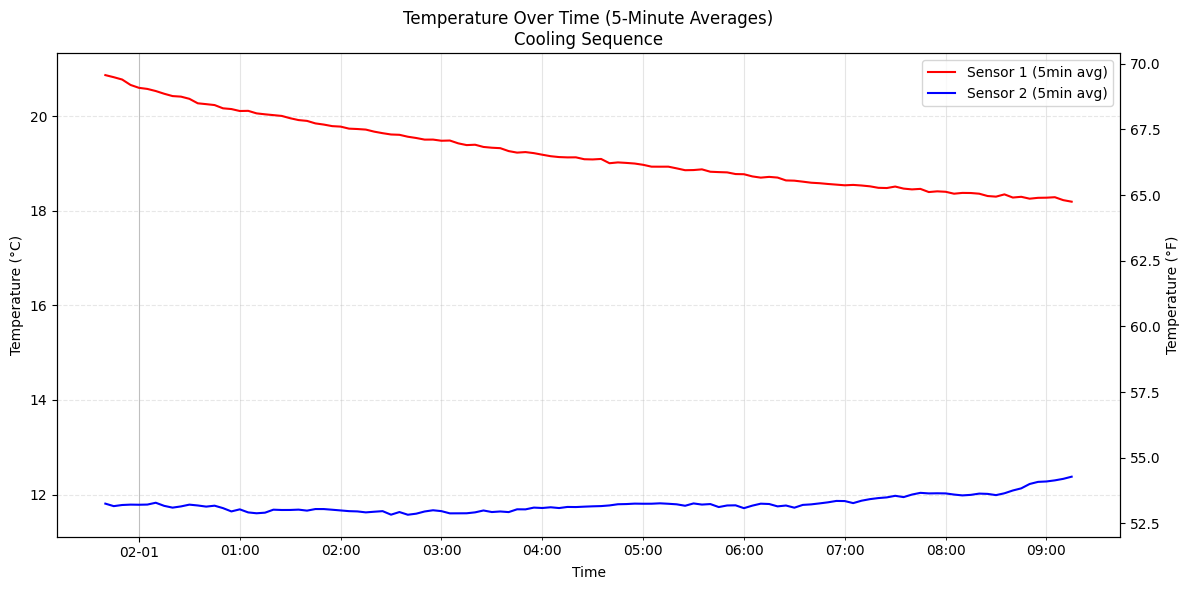

Sequence starts at: 2025-01-31 23:40:00
Sequence ends at: 2025-02-01 09:20:00
Sequence length: 116 points


In [4]:
# Calculate temperature differences for resampled data
temp_diff = df_resampled1.diff()

# Find sequences where temperature is not increasing (diff <= 0)
not_increasing = temp_diff <= 0

# Find runs of at least 10 points where temperature is not increasing
run_length = 0
start_idx = None
for i, (idx, is_not_inc) in enumerate(not_increasing.items()):
    if is_not_inc:
        run_length += 1
        if run_length == 10:  # We found our sequence
            start_idx = i - 9  # Go back to start of sequence
            break
    else:
        run_length = 0

if start_idx is not None:
    # Find where temperature starts increasing for 4 consecutive points
    end_idx = start_idx + 10
    while end_idx < len(temp_diff) - 3:  # Need room for 4 points
        if (temp_diff.iloc[end_idx] > 0 and 
            temp_diff.iloc[end_idx + 1] > 0 and 
            temp_diff.iloc[end_idx + 2] > 0 and 
            temp_diff.iloc[end_idx + 3] > 0):
            break
        end_idx += 1
    
    # Get the timestamps for these indices
    start_time = not_increasing.index[start_idx]
    end_time = not_increasing.index[end_idx]
    
    # Select data for this time range
    mask = (df_resampled1.index >= start_time) & (df_resampled1.index < end_time)
    df_resampled1_selected = df_resampled1[mask]
    df_resampled2_selected = df_resampled2[mask]
    
    # Create the plot
    fig, ax1 = plt.subplots(figsize=(12, 6))
    ax2 = ax1.twinx()
    
    # Plot the selected data
    ax1.plot(df_resampled1_selected.index, df_resampled1_selected.values, '-r', 
             linewidth=1.5, label=f'Sensor 1 ({resample_minutes}min avg)')
    ax1.plot(df_resampled2_selected.index, df_resampled2_selected.values, '-b', 
             linewidth=1.5, label=f'Sensor 2 ({resample_minutes}min avg)')
    
    # Customize the plot
    ax1.set_title(f'Temperature Over Time ({resample_minutes}-Minute Averages)\nCooling Sequence')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Temperature (°C)')
    ax2.set_ylabel('Temperature (°F)')
    
    # Set up Fahrenheit axis limits based on Celsius limits
    c_min, c_max = ax1.get_ylim()
    ax2.set_ylim((c_min * 9/5 + 32), (c_max * 9/5 + 32))
    
    # Set up grid
    ax1.grid(True, which='major', axis='x', linestyle='-', color='gray', alpha=0.5)
    ax1.grid(True, which='minor', axis='x', linestyle='-', color='gray', alpha=0.2)
    ax1.grid(True, axis='y', linestyle='--', alpha=0.3)
    
    # Format x-axis
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    ax1.xaxis.set_major_locator(mdates.DayLocator())
    ax1.xaxis.set_minor_formatter(mdates.DateFormatter('%H:%M'))
    ax1.xaxis.set_minor_locator(mdates.HourLocator())
    
    plt.xticks(rotation=45)
    
    # Add legend
    lines1, labels1 = ax1.get_legend_handles_labels()
    ax1.legend(lines1, labels1, loc='upper right')
    
    plt.tight_layout()
    plt.show()
    
    print(f"Sequence starts at: {start_time}")
    print(f"Sequence ends at: {end_time}")
    print(f"Sequence length: {len(df_resampled1_selected)} points")
else:
    print("No sequence of 10 or more non-increasing points found")

Here is my prompt for fitting this:

```Ok, now I want to fit Newton's law of cooling to the df_resampled1_selected temperature curve to find the decay timescale.  Specifically, I want to fit the curve  T_in(time) = T_out(time) + (T_in(0) - T_out(time))*exp(- time/tau). where T_in is df_resampled1_selected temperature and T_out is df_resampled2_selected temperature.  For the moment, time == 0 is the beginning of this selected subsample.  I want to find the best fit value for tau via a least-squares technique.```

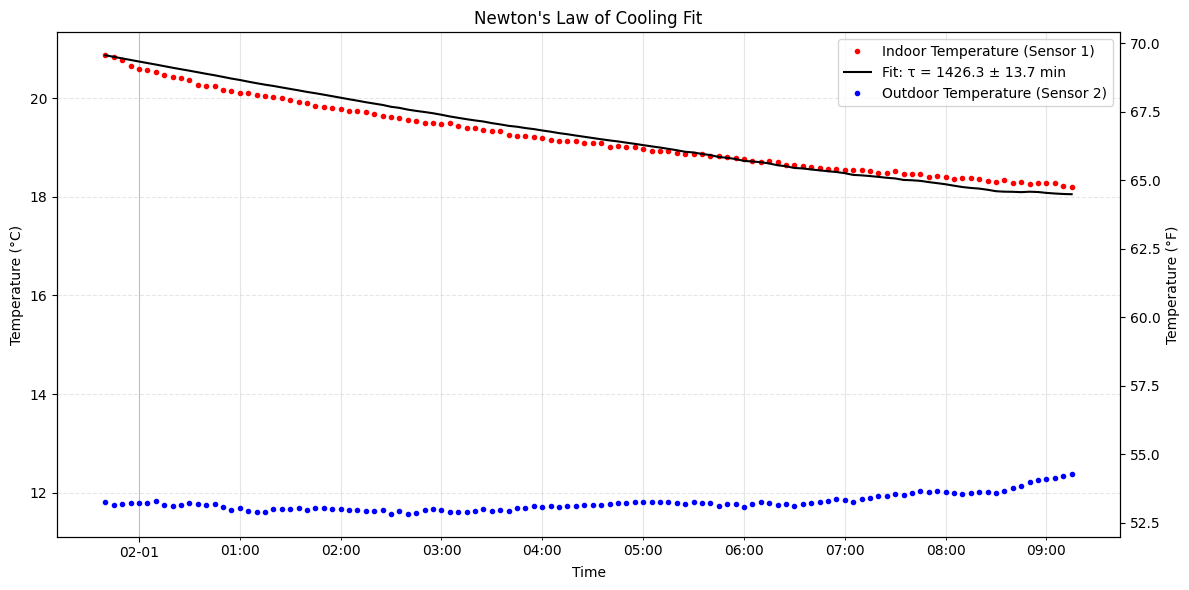

Fitted time constant (tau) = 1426.3 ± 13.7 minutes
                           = 23.8 ± 0.2 hours


In [5]:
from scipy.optimize import curve_fit
import numpy as np

# Convert timestamps to minutes since start
time_minutes = (df_resampled1_selected.index - df_resampled1_selected.index[0]).total_seconds() / 60.0

# Define the cooling function
def cooling_law(t, tau):
    T_out = df_resampled2_selected.values  # outdoor temperature at each time
    T_in_0 = df_resampled1_selected.values[0]  # initial indoor temperature
    return T_out + (T_in_0 - T_out) * np.exp(-t/tau)

# Perform the fit
popt, pcov = curve_fit(cooling_law, time_minutes, df_resampled1_selected.values)
tau_fit = popt[0]
tau_err = np.sqrt(pcov[0,0])

# Generate fitted curve
T_fit = cooling_law(time_minutes, tau_fit)

# Plot the results
fig, ax1 = plt.subplots(figsize=(12, 6))
ax2 = ax1.twinx()

# Plot data and fit
ax1.plot(df_resampled1_selected.index, df_resampled1_selected.values, 'r.', 
         label=f'Indoor Temperature (Sensor 1)')
ax1.plot(df_resampled1_selected.index, T_fit, 'k-', 
         label=f'Fit: τ = {tau_fit:.1f} ± {tau_err:.1f} min')
ax1.plot(df_resampled2_selected.index, df_resampled2_selected.values, 'b.', 
         label='Outdoor Temperature (Sensor 2)')

# Customize the plot
ax1.set_title('Newton\'s Law of Cooling Fit')
ax1.set_xlabel('Time')
ax1.set_ylabel('Temperature (°C)')
ax2.set_ylabel('Temperature (°F)')

# Set up Fahrenheit axis limits based on Celsius limits
c_min, c_max = ax1.get_ylim()
ax2.set_ylim((c_min * 9/5 + 32), (c_max * 9/5 + 32))

# Set up grid
ax1.grid(True, which='major', axis='x', linestyle='-', color='gray', alpha=0.5)
ax1.grid(True, which='minor', axis='x', linestyle='-', color='gray', alpha=0.2)
ax1.grid(True, axis='y', linestyle='--', alpha=0.3)

# Format x-axis
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
ax1.xaxis.set_major_locator(mdates.DayLocator())
ax1.xaxis.set_minor_formatter(mdates.DateFormatter('%H:%M'))
ax1.xaxis.set_minor_locator(mdates.HourLocator())

plt.xticks(rotation=45)

# Add legend
lines1, labels1 = ax1.get_legend_handles_labels()
ax1.legend(lines1, labels1, loc='upper right')

plt.tight_layout()
plt.show()

print(f"Fitted time constant (tau) = {tau_fit:.1f} ± {tau_err:.1f} minutes")
print(f"                           = {tau_fit/60:.1f} ± {tau_err/60:.1f} hours")

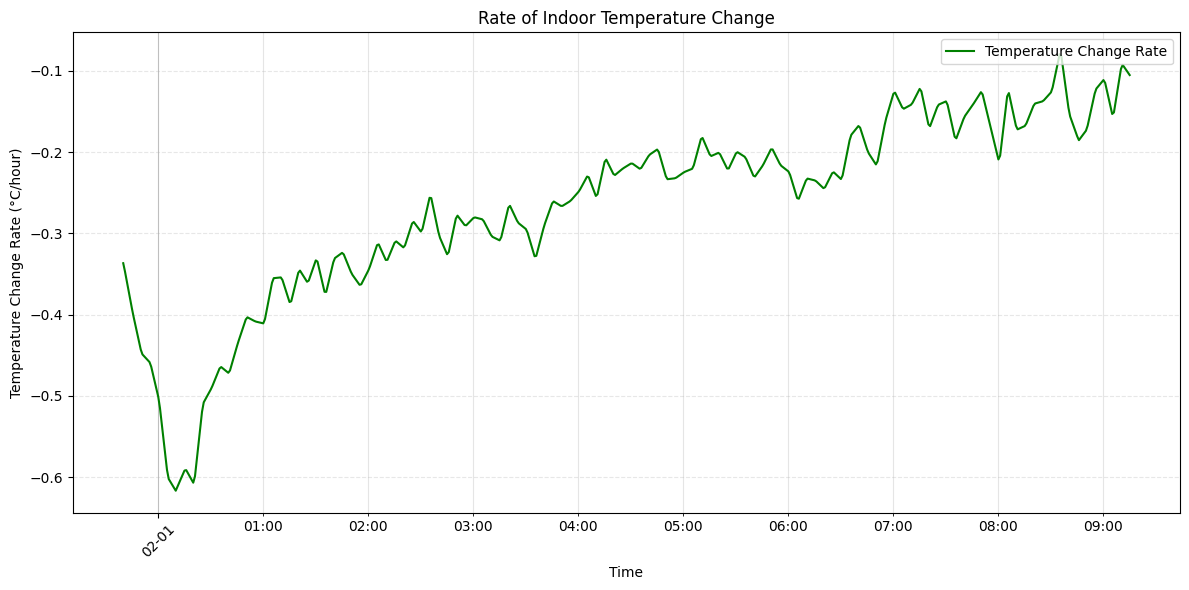

In [6]:
# Calculate smoothed derivative of indoor temperature
# First resample to regular intervals and interpolate
regular_time = pd.date_range(start=df_resampled1_selected.index[0], 
                           end=df_resampled1_selected.index[-1],
                           freq='1min')
temp_interp = pd.Series(index=regular_time, 
                       data=np.interp(mdates.date2num(regular_time),
                                    mdates.date2num(df_resampled1_selected.index),
                                    df_resampled1_selected.values))

# Calculate derivative and smooth it
window = 60  # 1 hour window for smoothing
dt = 1/60  # time step in hours
dT_dt = np.gradient(temp_interp.values) / dt  # degrees per hour
dT_dt_smooth = pd.Series(index=temp_interp.index,
                        data=np.convolve(dT_dt, np.ones(window)/window, mode='same'))

# Plot the results
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot smoothed derivative
ax1.plot(temp_interp.index, dT_dt_smooth, 'g-', 
         label='Temperature Change Rate')

# Customize the plot
ax1.set_title('Rate of Indoor Temperature Change')
ax1.set_xlabel('Time')
ax1.set_ylabel('Temperature Change Rate (°C/hour)')

# Set up grid
ax1.grid(True, which='major', axis='x', linestyle='-', color='gray', alpha=0.5)
ax1.grid(True, which='minor', axis='x', linestyle='-', color='gray', alpha=0.2)
ax1.grid(True, axis='y', linestyle='--', alpha=0.3)

# Format x-axis
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
ax1.xaxis.set_major_locator(mdates.DayLocator())
ax1.xaxis.set_minor_formatter(mdates.DateFormatter('%H:%M'))
ax1.xaxis.set_minor_locator(mdates.HourLocator())

plt.xticks(rotation=45)

# Add legend
ax1.legend(loc='upper right')

plt.tight_layout()
plt.show()


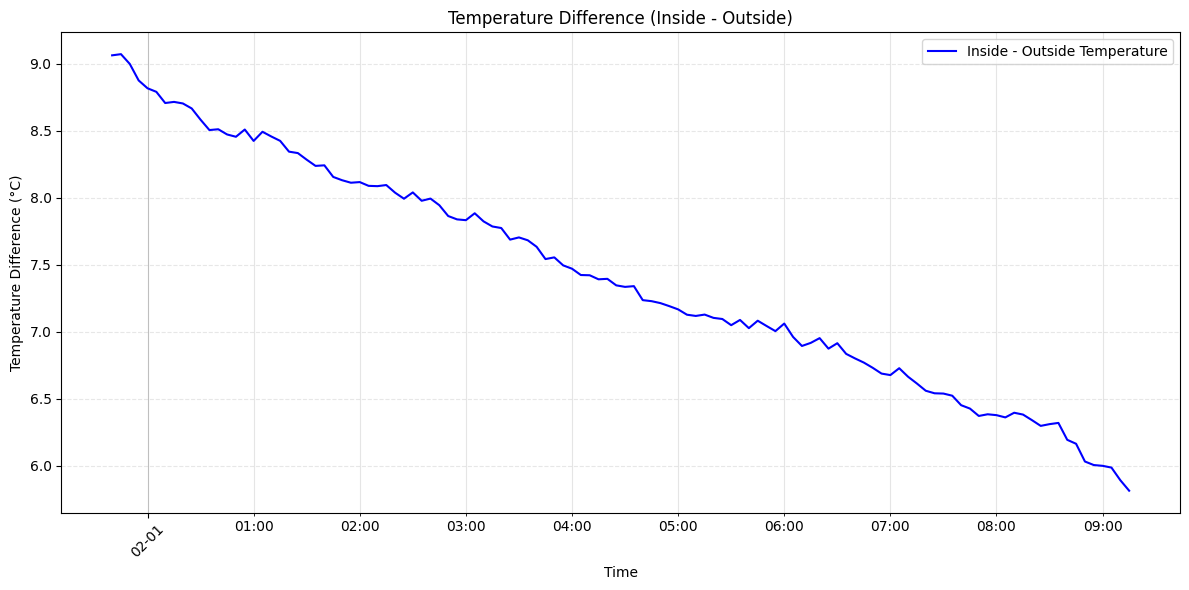

In [7]:
# Calculate temperature difference (inside - outside)
temp_diff = df_resampled1_selected - df_resampled2_selected

# Plot temperature difference
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot temperature difference
ax1.plot(temp_diff.index, temp_diff.values, 'b-', 
         label='Inside - Outside Temperature')

# Customize the plot
ax1.set_title('Temperature Difference (Inside - Outside)')
ax1.set_xlabel('Time')
ax1.set_ylabel('Temperature Difference (°C)')

# Set up grid
ax1.grid(True, which='major', axis='x', linestyle='-', color='gray', alpha=0.5)
ax1.grid(True, which='minor', axis='x', linestyle='-', color='gray', alpha=0.2)
ax1.grid(True, axis='y', linestyle='--', alpha=0.3)

# Format x-axis
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
ax1.xaxis.set_major_locator(mdates.DayLocator())
ax1.xaxis.set_minor_formatter(mdates.DateFormatter('%H:%M'))
ax1.xaxis.set_minor_locator(mdates.HourLocator())

plt.xticks(rotation=45)

# Add legend
ax1.legend(loc='upper right')

plt.tight_layout()
plt.show()


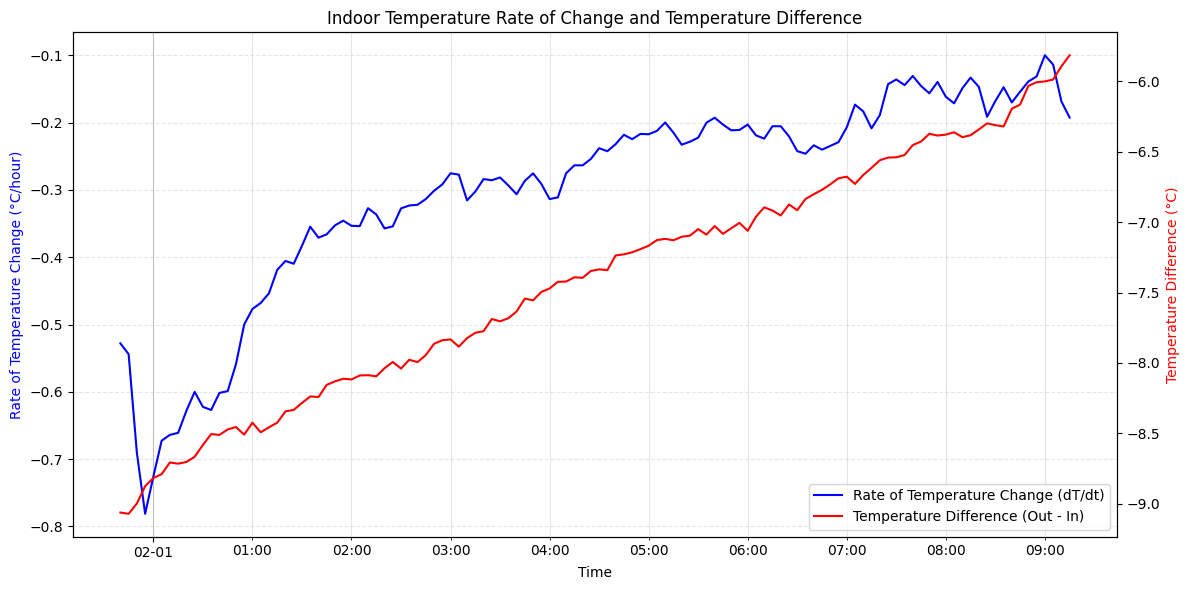

In [8]:
# Calculate dT_in/dt using central differences and smooth with rolling average
dt = (df_resampled1_selected.index[1] - df_resampled1_selected.index[0]).total_seconds()
dT_dt = np.gradient(df_resampled1_selected.values, dt)
dT_dt_smooth = pd.Series(dT_dt, index=df_resampled1_selected.index).rolling(window='1h').mean()

# Convert from degrees/sec to degrees/hour
dT_dt_smooth_hourly = dT_dt_smooth * 3600  # multiply by seconds per hour

# Create figure with two y-axes
fig, ax1 = plt.subplots(figsize=(12, 6))
ax2 = ax1.twinx()

# Plot dT/dt on left axis
ax1.plot(df_resampled1_selected.index, dT_dt_smooth_hourly, 'b-', 
         label='Rate of Temperature Change (dT/dt)')

# Plot temperature difference on right axis
ax2.plot(temp_diff.index, -temp_diff.values, 'r-', 
         label='Temperature Difference (Out - In)')

# Customize the plot
ax1.set_xlabel('Time')
ax1.set_ylabel('Rate of Temperature Change (°C/hour)', color='b')
ax2.set_ylabel('Temperature Difference (°C)', color='r')

# Set title
plt.title('Indoor Temperature Rate of Change and Temperature Difference')

# Set up grid
ax1.grid(True, which='major', axis='x', linestyle='-', color='gray', alpha=0.5)
ax1.grid(True, which='minor', axis='x', linestyle='-', color='gray', alpha=0.2)
ax1.grid(True, axis='y', linestyle='--', alpha=0.3)

# Format x-axis
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
ax1.xaxis.set_major_locator(mdates.DayLocator())
ax1.xaxis.set_minor_formatter(mdates.DateFormatter('%H:%M'))
ax1.xaxis.set_minor_locator(mdates.HourLocator())

plt.xticks(rotation=45)

# Add legends for both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='lower right')

plt.tight_layout()
plt.show()


In [9]:
# Estimate the value of tau, in hours, at the left and right ends of the above plot
9.0/0.75, 6.0/0.15

(12.0, 40.0)

The following figure is important.  It shows that the cooling constant, `τ = (T_out - T_in) / (dT_in/dt)` (i.e. the ratio of the curves plotted above) varies substantially, and roughly linearly, with time, from about 12 hours to 40 hours or so.  This implies that Newton's law of cooling isn't a particularly good fit for this data.

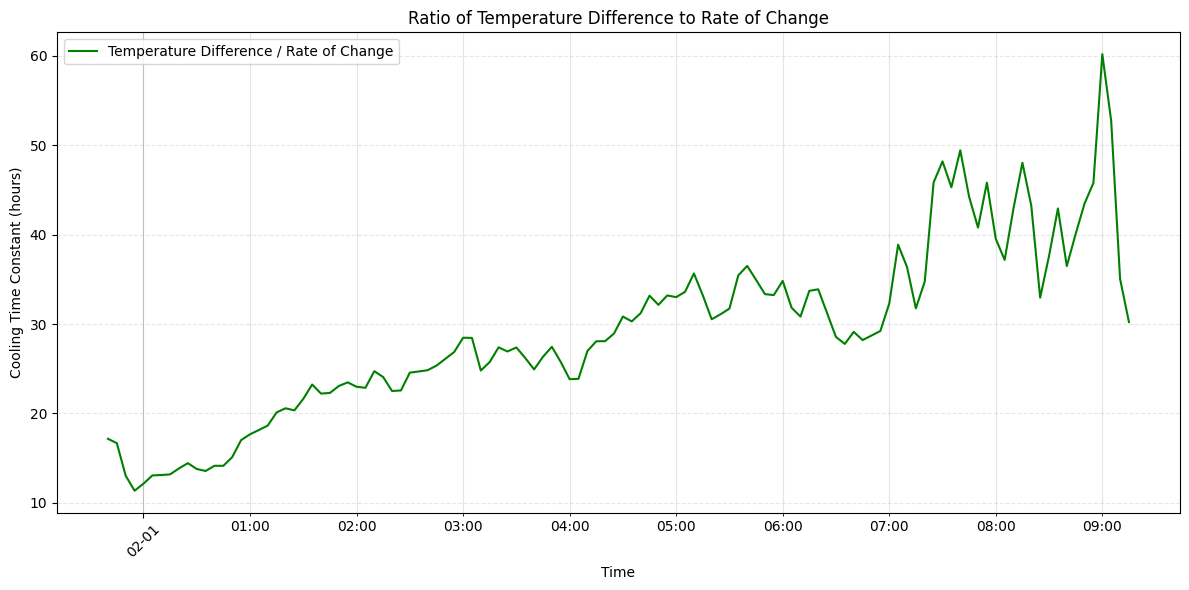

In [10]:
# Create figure
fig, ax = plt.subplots(figsize=(12,6))

# Calculate ratio of temperature difference to rate of change
# Using negative temp diff to match previous sign convention
ratio = (-temp_diff.values) / dT_dt_smooth_hourly

# Plot the ratio
ax.plot(df_resampled1_selected.index, ratio, 'g-', 
        label='Temperature Difference / Rate of Change')

ax.set_title('Ratio of Temperature Difference to Rate of Change')
ax.set_xlabel('Time')
ax.set_ylabel('Cooling Time Constant (hours)')

# Set up grid
ax.grid(True, which='major', axis='x', linestyle='-', color='gray', alpha=0.5)
ax.grid(True, which='minor', axis='x', linestyle='-', color='gray', alpha=0.2)
ax.grid(True, axis='y', linestyle='--', alpha=0.3)

# Format x-axis
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
ax.xaxis.set_major_locator(mdates.DayLocator())
ax.xaxis.set_minor_formatter(mdates.DateFormatter('%H:%M'))
ax.xaxis.set_minor_locator(mdates.HourLocator())

plt.xticks(rotation=45)
ax.legend()
plt.tight_layout()
plt.show()


Best fit time constant tau = 63480.6 seconds (17.6 hours)


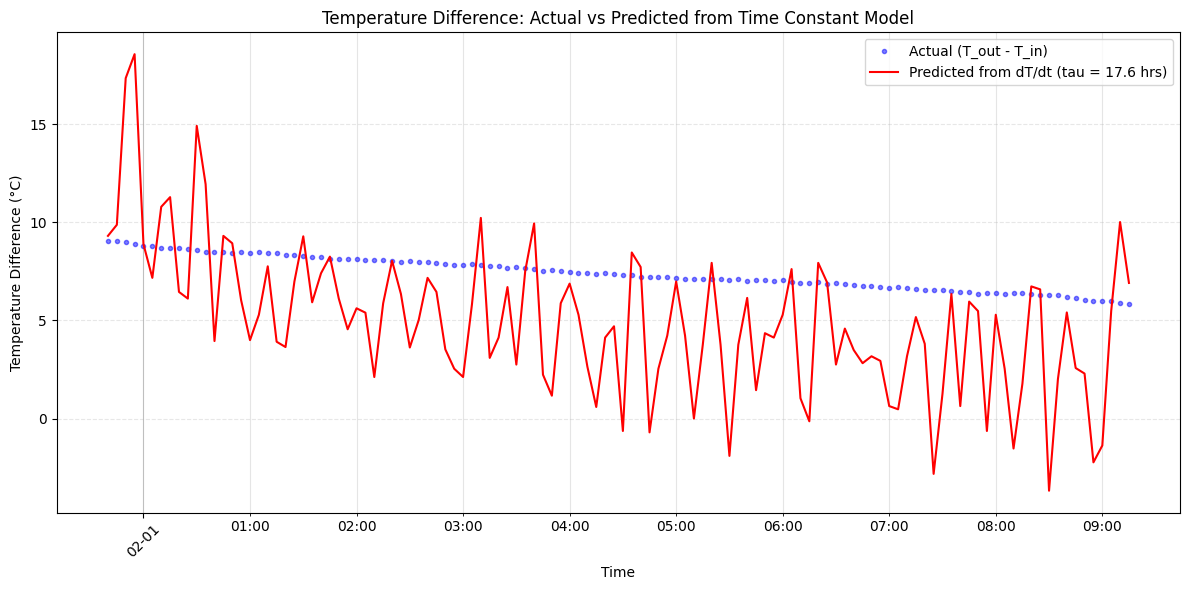

In [11]:
# Calculate dT_in/dt using central differences
dt = (df_resampled1_selected.index[1] - df_resampled1_selected.index[0]).total_seconds()
dT_dt = np.gradient(df_resampled1_selected.values, dt)

# Set up least squares problem: (T_out - T_in)/tau = dT_in/dt
# Rearranging: dT_in/dt * tau = T_out - T_in
# Or: dT_in/dt * tau + T_in = T_out
A = dT_dt
b = df_resampled2_selected.values - df_resampled1_selected.values

# Solve for tau using least squares
tau = np.linalg.lstsq(A.reshape(-1,1), b, rcond=None)[0][0]

print(f"Best fit time constant tau = {tau:.1f} seconds ({tau/3600:.1f} hours)")

# Plot the fit
fig, ax = plt.subplots(figsize=(12,6))

# Plot actual temperature difference
ax.plot(temp_diff.index, temp_diff.values, 'b.', alpha=0.5,
        label='Actual (T_out - T_in)')

# Plot predicted temperature difference based on dT/dt and tau
ax.plot(temp_diff.index, -dT_dt * tau, 'r-', 
        label=f'Predicted from dT/dt (tau = {tau/3600:.1f} hrs)')

ax.set_title('Temperature Difference: Actual vs Predicted from Time Constant Model')
ax.set_xlabel('Time') 
ax.set_ylabel('Temperature Difference (°C)')

# Set up grid
ax.grid(True, which='major', axis='x', linestyle='-', color='gray', alpha=0.5)
ax.grid(True, which='minor', axis='x', linestyle='-', color='gray', alpha=0.2)
ax.grid(True, axis='y', linestyle='--', alpha=0.3)

# Format x-axis
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
ax.xaxis.set_major_locator(mdates.DayLocator())
ax.xaxis.set_minor_formatter(mdates.DateFormatter('%H:%M'))
ax.xaxis.set_minor_locator(mdates.HourLocator())

plt.xticks(rotation=45)
ax.legend()
plt.tight_layout()
plt.show()


In [12]:
tau_fit  # 1426.34

np.float64(1426.344152543803)

Below we set the time-scale, tau_fit to some value represented by the data (for example, at early times tau ~ 12 hours or so, but at later times tau ~ 30 or 40 hours).  One can see that smaller values of tau fit the early part part of the cooling curve, but larger (longer) values of tau (particularly ~ 24 hours) tend to fit the entire duration best, but not the finer structure of the decay curve.  

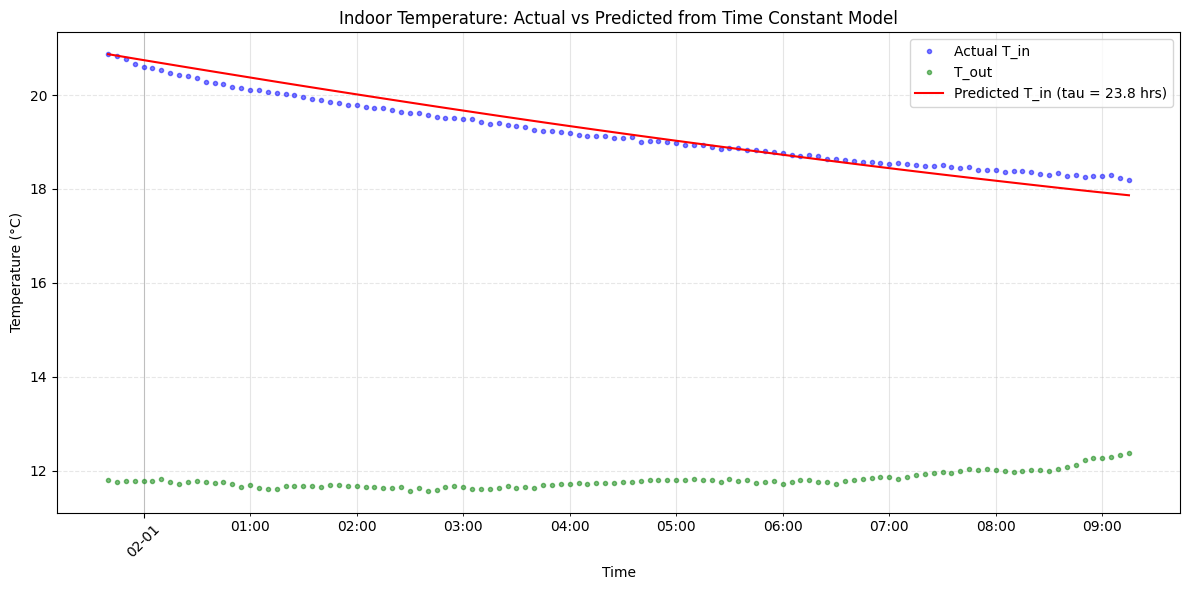

In [13]:
# tau_fit = 17.6 * 60 # 17.6 hours
# tau_fit = 24 * 60 # 24 hours

# Numerically integrate dT_in/dt = (T_out - T_in)/tau
from scipy.integrate import odeint
from scipy.interpolate import interp1d

# Convert tau_fit from minutes to seconds to match our time units
tau_seconds = tau_fit * 60  # convert minutes to seconds

# Define the ODE: dT/dt = (T_out - T)/tau
def dTdt(T, t, T_out_interp, tau):
    T_out = T_out_interp(t)  # Get T_out at current time
    return (T_out - T) / tau

# Create interpolation function for T_out with bounds handling
times = (df_resampled2_selected.index - df_resampled2_selected.index[0]).total_seconds()
T_out_interp = interp1d(times, df_resampled2_selected.values, 
                        bounds_error=False, fill_value='extrapolate')

# Initial condition is first T_in value
T0 = df_resampled1_selected.values[0]

# Solve ODE
T_predicted = odeint(dTdt, T0, times, args=(T_out_interp, tau_seconds))

# Plot results
fig, ax = plt.subplots(figsize=(12,6))

# Plot actual temperatures
ax.plot(df_resampled1_selected.index, df_resampled1_selected.values, 'b.', alpha=0.5,
        label='Actual T_in')
ax.plot(df_resampled2_selected.index, df_resampled2_selected.values, 'g.', alpha=0.5,
        label='T_out')

# Plot predicted T_in from ODE integration
ax.plot(df_resampled1_selected.index, T_predicted, 'r-', 
        label=f'Predicted T_in (tau = {tau_fit/60:.1f} hrs)')

ax.set_title('Indoor Temperature: Actual vs Predicted from Time Constant Model')
ax.set_xlabel('Time')
ax.set_ylabel('Temperature (°C)')

# Set up grid
ax.grid(True, which='major', axis='x', linestyle='-', color='gray', alpha=0.5)
ax.grid(True, which='minor', axis='x', linestyle='-', color='gray', alpha=0.2)
ax.grid(True, axis='y', linestyle='--', alpha=0.3)

# Format x-axis
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
ax.xaxis.set_major_locator(mdates.DayLocator())
ax.xaxis.set_minor_formatter(mdates.DateFormatter('%H:%M'))
ax.xaxis.set_minor_locator(mdates.HourLocator())

plt.xticks(rotation=45)
ax.legend()
plt.tight_layout()
plt.show()